In [4]:
import rasterio
import matplotlib.pyplot as plt
import geopandas as gpd
from pathlib import Path

from app.processing.calculate_flooding_area import map_flooding_area_to_geojson, calculate_flooding_area_km2
from app.processing.calculate_affected_roads import calculate_road_impact_m
from app.processing.calculate_population_impact import calculate_population_impact

example_files_path = Path.cwd() / "data"

# The analysis

My process was to first find the data. I wanted to check visual data first but since most of the imagery was cloudy, I decided to use VV radar data. I made a composite of the radar data before and during the storm data, which resulted in the following maps:

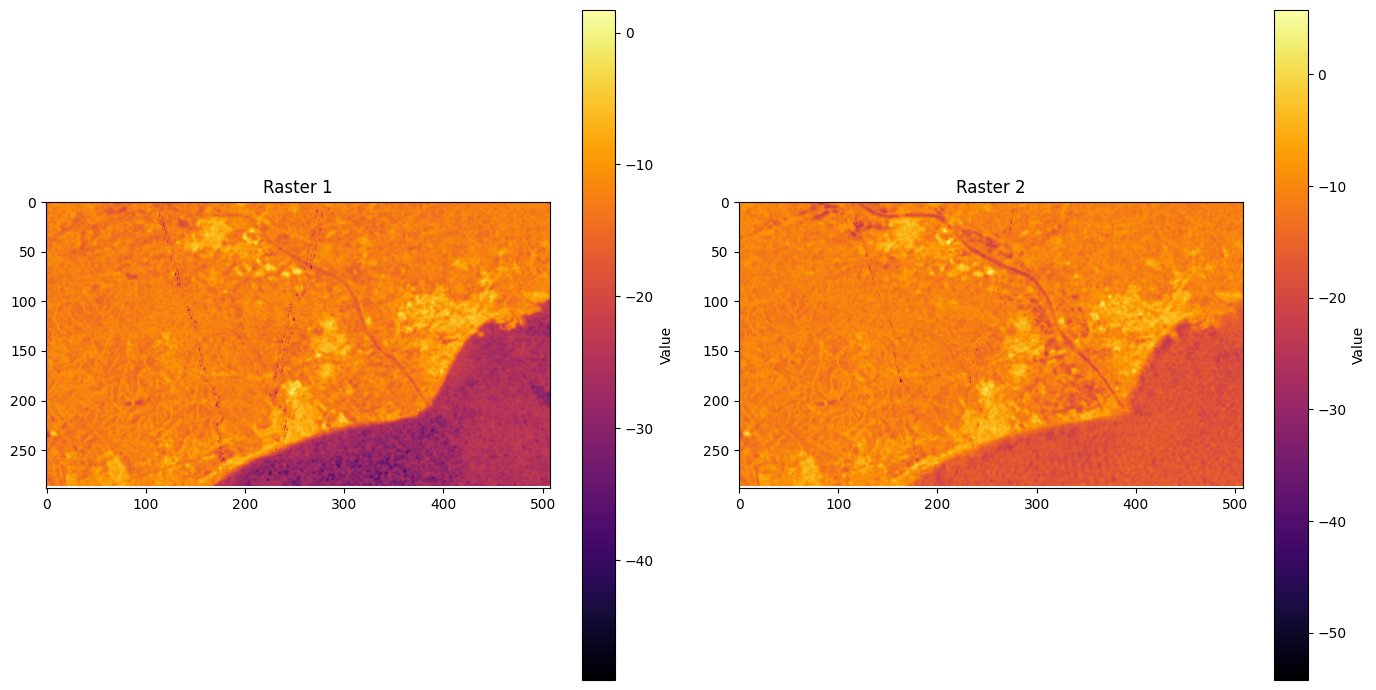

In [5]:
def plot_rasters_side_by_side(raster1_path: str, raster2_path: str, cmap: str = 'inferno'):
    with rasterio.open(raster1_path) as src1:
        data1 = src1.read(1) 

    with rasterio.open(raster2_path) as src2:
        data2 = src2.read(1)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))  # 1 row, 2 columns

    im1 = axes[0].imshow(data1, cmap=cmap)
    axes[0].set_title("Raster 1")
    fig.colorbar(im1, ax=axes[0], label="Value")

    im2 = axes[1].imshow(data2, cmap=cmap)
    axes[1].set_title("Raster 2")
    fig.colorbar(im2, ax=axes[1], label="Value")

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

before_raster_path = example_files_path / 'Before_Flood.tif'
after_raster_path = example_files_path / 'After_Flood.tif'

plot_rasters_side_by_side(before_raster_path, after_raster_path, cmap='inferno')

You can definitely see more dark spots on the right, so next I decided to subract the rasters and then mask the areas above a certain threshold. Threshold 2 looks about right. 

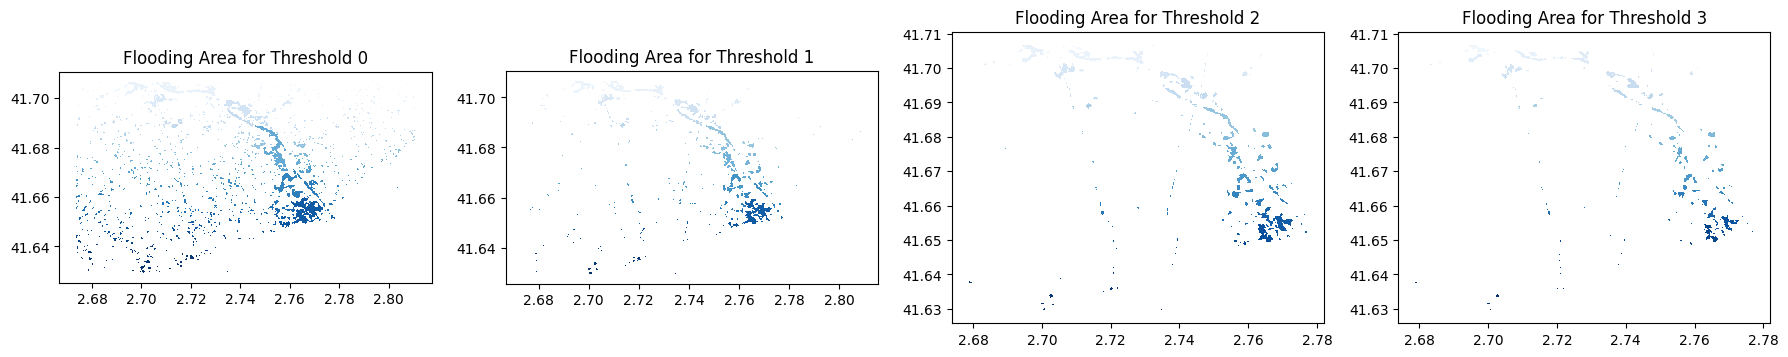

In [6]:
fig, axes = plt.subplots(1, 4, figsize=(18, 6))

for i, threshold in enumerate([0, 1, 2, 3]):
    # Generate the GeoJSON object based on the threshold
    geo_json = map_flooding_area_to_geojson(
        after=example_files_path / 'After_Flood.tif',
        before=example_files_path / 'Before_Flood.tif',
        threshold=threshold
    )

    # Convert the GeoJSON dictionary to a GeoDataFrame
    gdf = gpd.GeoDataFrame.from_features(geo_json['features'])

    # Plot the GeoDataFrame in the appropriate subplot (using axes[i])
    ax = axes[i]
    gdf.plot(ax=ax, cmap='Blues')  # You can choose any color map
    ax.set_title(f"Flooding Area for Threshold {threshold}")

# Adjust the layout to avoid overlapping plots
plt.tight_layout()

# Show the plot
plt.show()


Then we can calculate all the results:

In [7]:
print("population impacted: ",calculate_population_impact(flooding_areas=example_files_path / "flood_polygons.geojson", population=example_files_path / "esp_pd_2020_1km.tif"))
print("flooding area km2: ",calculate_flooding_area_km2(example_files_path / "After_Flood.tif", example_files_path / "Before_Flood.tif", threshold=2))
print("road impacted m: ",calculate_road_impact_m(roads=example_files_path / "roads.geojson",flooding_areas=example_files_path / "flood_polygons.geojson"))


EPSG:4326
population impacted:  40951.6015625
flooding area km2:  70.0326


/home/derek/research/maresme-county-gloria/app/processing/calculate_population_impact.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  only_large_polygons = polygons[polygons.geometry.area >= polygon_size_filter]
Skipping field highway: unsupported OGR type: 5
Skipping field lanes: unsupported OGR type: 5
Skipping field maxspeed: unsupported OGR type: 5
Skipping field name: unsupported OGR type: 5
Skipping field ref: unsupported OGR type: 5
Skipping field width: unsupported OGR type: 5
/home/derek/research/maresme-county-gloria/app/processing/calculate_affected_roads.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  large_flooding = flooding_gdf[flooding_gdf.geometry.area >= polygon_size_filter]


road impacted m:  76658.76654104237
